# Xylo™-A3 `AFESim` Module Tutorial

Xylo™-A3 HDK contains a signal pre-processing module which is designed to encode an audio signal in the form of spike trains.
This module is named as **A**udio **F**ront-**E**nd, and it efficiently:

* captures audio from a microphone, 
* converts analog signals into digital waveforms, 
* performs band-pass filtering to isolate specific frequency ranges, 
* encodes signals into spike trains, 
* and ultimately delivers these spike trains to the Spiking Neural Network (SNN) core.

Here in this tutorial, we will introduce `AFESim`, the simulated counterpart of actual `AFE` module. This tutorial covers the usage and functionalities of `AFESim` in a beginner friendly manner.


## Getting Started

Let's first investigate the block diagram of the input pre-processing pipeline

In [1]:
from IPython.display import Image

Image("figures/av3_block.png")


There comes:
* Filter Bank
* Divisive Normalization or IAF spike generation
* Rastering

The Filter bank is a set of 16 band-pass filters, optimized to cover the frequency range of the human voice. 
The output of each filter is a 14-bit integer signal. 
The output of the filter bank is a 16-channel 14-bit integer signal.

After the filter bank, the signal is passed through a divisive normalization block.
Divisive normalization provides a way to set dynamic, **adaptive thresholds** for spike generation depending on the instantaneous power of the signal.
The alternative path to the divisive normalization is the IAF spike generation block.
The IAF spike generation block generates spikes with a fixed threshold.

The output of the divisive normalization or the IAF spike generation block is 16-channel 1-bit spike trains.
This spike trains are accumulated in a 16-channel 4-bit rasters.
The rasters are the final output of the AFE block, and they are sent to the SNN core.

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from rockpool.devices.xylo.syns65302 import AFESim, AUDIO_SAMPLING_RATE
from rockpool.timeseries import TSContinuous, TSEvent


from samna.xyloA3.configuration import InputInterfaceConfig


## Load an audio file

To start with, we need to load an audio file. The audio file we'll use is a chirp signal whose frequency increases linearly from 20 Hz to 20 kHz in 4 seconds. The sampling rate of the audio file is ~48.8 kHz. If you would like to try with your own audio file, please make sure that the sampling rate is the same. You can use `generate_chirp.py` to generate a new chirp signal. 

Let's load the audio file and plot the waveform! For the sake of visualisation, we will only use the first 0.1 second of the audio file.

In [3]:
# Load the audio recording using librosa

filename = "freq_sweep.wav"
y, sr = librosa.load(filename, sr=None)

# Also load the frequency sweep data from the AFESim
freq_sw = np.load(filename.replace(".wav", ".npy"))


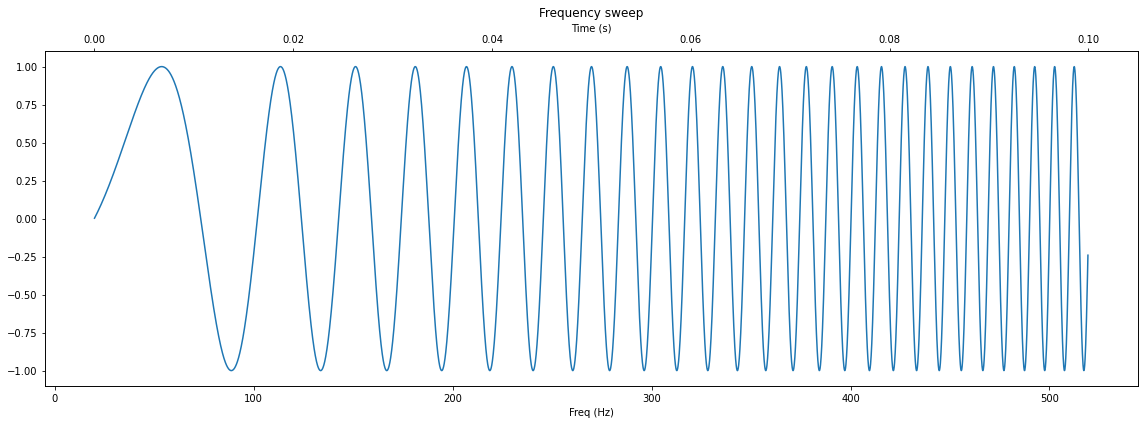

In [4]:
# - Plot the first 0.1 seconds of the audio recording

t = 0.1
T = int(t * sr)
fig, ax1 = plt.subplots(figsize=(16, 6))

# - Plot the frequency sweep
ax1.plot(freq_sw[:T], y[:T])
ax1.xaxis.tick_bottom()
ax1.set_xlabel("Freq (Hz)")
ax1.xaxis.set_label_position("bottom")

# - Plot the time axis
ax2 = ax1.twiny()
ax2.plot(np.arange(0, t, 1 / sr)[:T], y[:T], alpha=0)
ax2.xaxis.tick_top()
ax2.set_xlabel("Time (s)")
ax2.xaxis.set_label_position("top")

# - Plot
plt.title("Frequency sweep")
plt.tight_layout()
plt.show()


## Quantize the signal to 14 bits

The output of the microphone ADC's are both 14-bit integers. So, we need to quantize the signal to 14 bits.

In [5]:
scale = 1
num_bits = 14
q_signal = np.vectorize(lambda __data: int(scale * __data * (2 ** (num_bits - 1))))(y)


## Construct AFESim

There are two methods to construct an `AFESim` object. The first one is to use the default constructor. When we use the default constructor, we have all low-level hardware parameters. The second method is to use the `.from_specification()` method. `.from_specification()` provides us with a more human comprehensible way to construct an `AFESim` object, but it might not always be possible to select the exact parameters we want due to hardware constraints. It'll check and complain if there is any hardware constraint violation, and suggest the closest possible parameters.

Let's first use the default constructor.

In [6]:
# - Utilize divisive normalization
afesim_dn = AFESim(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="divisive_norm",
    dn_rate_scale_bitshift=(6, 0),
    dn_low_pass_bitshift=12,
    dn_EPS=1,
    fixed_threshold_vec=None,
    down_sampling_factor=50,
)

# - Utilize IAF neurons
afesim_th = AFESim(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="threshold",
    dn_rate_scale_bitshift=None,
    dn_low_pass_bitshift=None,
    dn_EPS=None,
    fixed_threshold_vec=2**27,
    down_sampling_factor=50,
)


Here we have two options for the spike generation mode:

* `divisive_norm`
* `threshold`

When we select `"divisive_norm"`, the divisive normalization block is used for spike generation. When we select `"threshold"`, the IAF spike generation block is used for spike generation.

In the case of `"divisive_norm"`, we have three parameters to control:

* `"dn_rate_scale_bitshift"`
* `"dn_low_pass_bitshift"`
* `"dn_EPS"`

`"fixed_threshold_vec"` is the parameter to control in the case of `"threshold"`. The `"fixed_threshold_vec"` is ignored in the case of `"divisive_norm"`, and the three parameters above are ignored in the case of `"threshold"`.


Let's check the docstring to see what these parameters are actually doing.

In [7]:
help(AFESim.__init__)


Help on function __init__ in module rockpool.devices.xylo.syns65302.afe_sim:

__init__(self, select_filters: 'Optional[Tuple[int]]' = None, spike_gen_mode: 'str' = 'divisive_norm', dn_rate_scale_bitshift: 'Optional[Tuple[int]]' = (6, 0), dn_low_pass_bitshift: 'Optional[int]' = 12, dn_EPS: 'Optional[Union[int, Tuple[int]]]' = 1, fixed_threshold_vec: 'Optional[Union[int, Tuple[int]]]' = 134217728, down_sampling_factor: 'int' = 50) -> 'None'
    AFESim constructor
    
    Args:
        select_filters (Optional[Tuple[int]], optional): The indices of the filters to be used in the filter bank. Defaults to None: use all filters.
            i.e. select_filters = (0,2,4,8,15) will use Filter 0, Filter 2, Filter 4, Filter 8, and Filter 15.
    
        spike_gen_mode (str, optional): The spike generation mode of the AFE. There are two ways to generate spikes, "divisive_norm" and "threshold". Defaults to "divisive_norm".
            When "divisive_norm" is selected, adaptive thresholds apply, a

Now let's check the `from_specification()`. The similar `"divisive_norm"` vs. `"threshold"` distinction applies here as well. The difference is that we have more human comprehensible parameters to control.

In case of `"divisive_norm"`, we have:
* `"rate_scale_factor"` instead of `"dn_rate_scale_bitshift"`
* `"low_pass_averaging_window"` instead of `"dn_low_pass_bitshift"`

When we try to set the `"rate_scale_factor"`, it will automatically calculate the closest possible `"dn_rate_scale_bitshift"` value. The same applies to `"low_pass_averaging_window"` and `"dn_low_pass_bitshift"`.

Additionally, we have `"dt"` which corresponds to `"down_sampling_factor"`.

The rest of the parameters are the same as the default constructor. Let's print the docstring and see the connection between the parameters.


In [8]:
help(AFESim.from_specification)


Help on method from_specification in module rockpool.devices.xylo.syns65302.afe_sim:

from_specification(select_filters: 'Optional[Tuple[int]]' = None, spike_gen_mode: 'str' = 'divisive_norm', rate_scale_factor: 'Optional[int]' = 63, low_pass_averaging_window: 'Optional[float]' = 0.084, dn_EPS: 'Optional[Union[int, Tuple[int]]]' = 1, fixed_threshold_vec: 'Optional[Union[int, Tuple[int]]]' = None, dt: 'Optional[float]' = 0.001024, **kwargs) -> 'AFESim' method of rockpool.nn.modules.module.PostInitMetaMixin instance
    Create an instance of AFESim by specifying higher level parameters for AFESim.
    
    Args:
        select_filters (Optional[Tuple[int]], optional): Check :py:class:`.AFESim`. Defaults to None.
        spike_gen_mode (str, optional): Check :py:class:`.AFESim`. Defaults to "divisive_norm".
        rate_scale_factor (Optional[int], optional): Target `rate_scale_factor` for the `DivisiveNormalization` module. Defaults to 63.
            Depended upon the dn_rate_scale_bits

Here we constructed the AFESim object from the specification, utilizing the divisive normalization block. Please feel free to play with the parameters and see how the output changes.

In [9]:
afesim = AFESim.from_specification(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="divisive_norm",
    rate_scale_factor=63,
    low_pass_averaging_window=84e-3,
    dn_EPS=1,
    fixed_threshold_vec=None,
    dt=1024e-6,
)


In [10]:
print("AFESim : ", afesim)
print("dt : ", afesim.dt)
print("low_pass_averaging_window : ", afesim.low_pass_averaging_window)
print("rate_scale_factor : ", afesim.rate_scale_factor)


AFESim :  AFESim  with shape (1, 16) {
    ChipButterworth '0_ChipButterworth' with shape (1, 16)
    DivisiveNormalization '1_DivisiveNormalization' with shape (16, 16)
    Raster '2_Raster' with shape (16, 16)
}
dt :  0.001024
low_pass_averaging_window :  0.08388608
rate_scale_factor :  63


## Run the simulation

We need to run the simulation to get the output. The output of the `AFESim` is a 16-channel 4-bit raster. However, there are also intermediate outputs which we can access. Below, we'll go through the outputs one by one.

First, let's run the simulation and get the output and the dictionaries.

In [18]:
out, state, rec = afesim(q_signal)


Lets print the record dictionary and see what we have.

In [12]:
print(rec.keys())


dict_keys(['0_ChipButterworth', '0_ChipButterworth_output', '1_DivisiveNormalization', '1_DivisiveNormalization_output', '2_Raster', '2_Raster_output'])


## Filter Bank output

The first stage is the filterbank, and we can fetch the output with key `"0_ChipButterworth_output"`. The filterbank output is a 16-channel (max) 14-bit integer signal, which is the input to the divisive normalization block.

In the case we select a sub-set of channels through `"select_filters"`, the filterbank output will have exactly the selected number of channels.
Let's plot and observe the filtering effect!

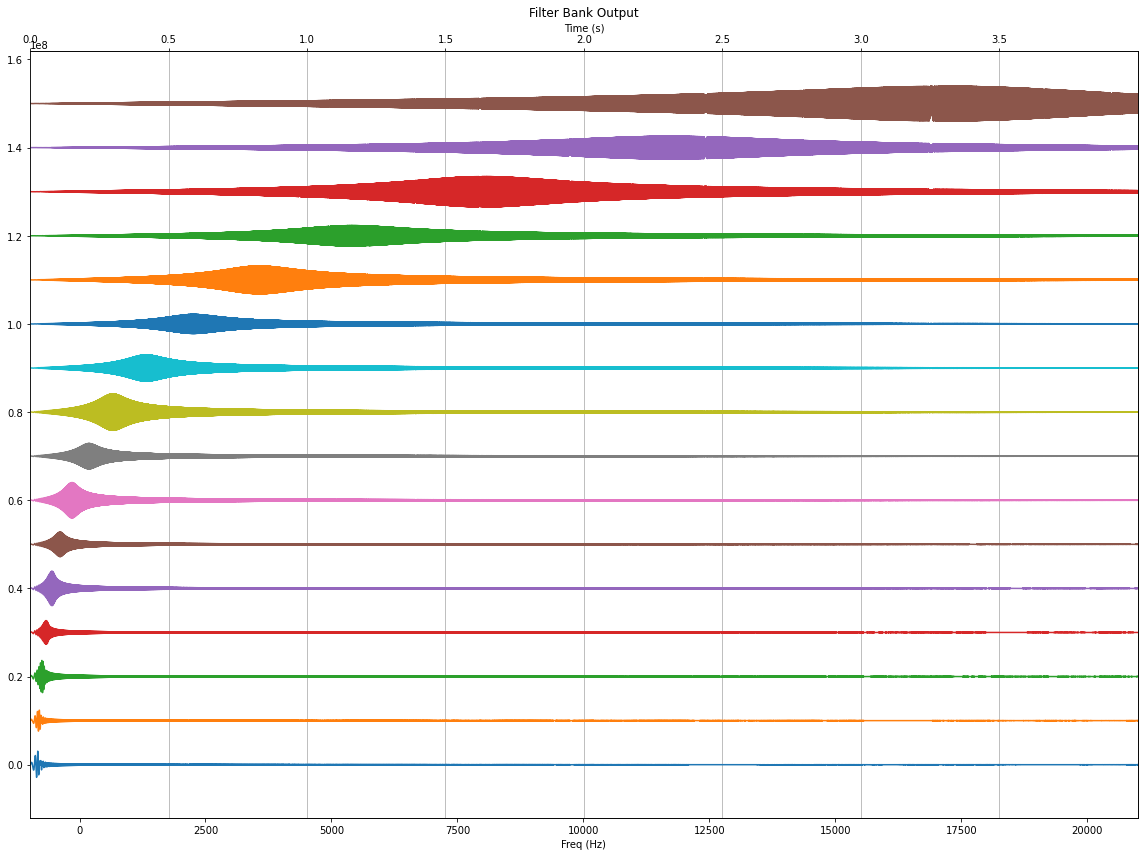

In [13]:
filtered_signal = rec["0_ChipButterworth_output"]
fig, ax1 = plt.subplots(figsize=(16, 12))

# - Plot the frequency sweep
ax1.plot(freq_sw, filtered_signal, alpha=0)
ax1.xaxis.tick_bottom()
ax1.set_xlabel("Freq (Hz)")
ax1.xaxis.set_label_position("bottom")

# - Plot the time axis
ax2 = ax1.twiny()
plt.sca(ax2)
TSContinuous.from_clocked(filtered_signal, dt=1 / sr).plot(stagger=1e7)
ax2.xaxis.tick_top()
ax2.set_xlabel("Time (s)")
ax2.xaxis.set_label_position("top")

# - Plot
plt.title("Filter Bank Output")
plt.tight_layout()
plt.grid()
plt.show()


As we can see, different filter channels apply different band-pass filters to the input signal. The lower index channels pass lower band frequencies, and the higher index channels higher band frequencies.

## Spike Encoding

The second stage is the spike generation, and we can fetch the output with key `"1_DivisiveNormalization_output"`. The divisive normalization output is 16-channel (max) **1-bit** spike train.

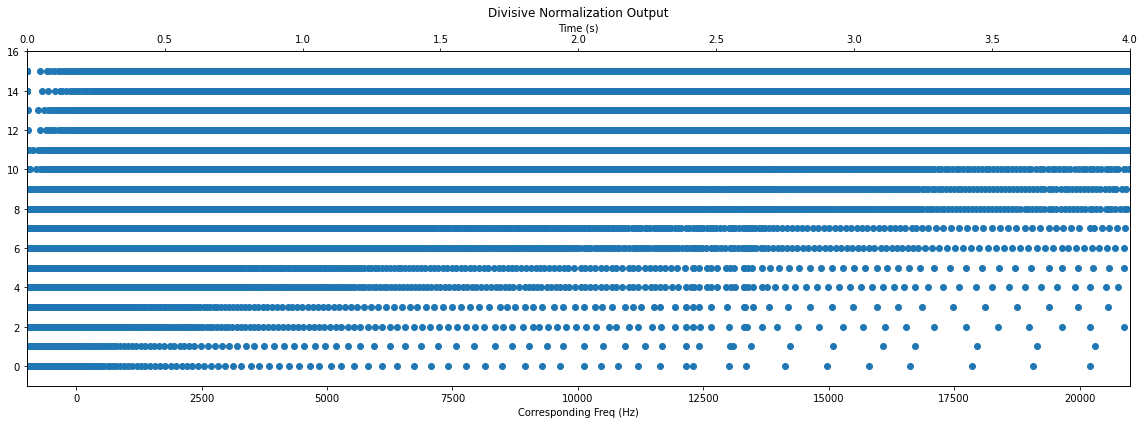

In [14]:
spike_out_div = rec["1_DivisiveNormalization_output"]
fig, ax = plt.subplots(figsize=(16, 6))

# - Plot the frequency sweep
ax.plot(freq_sw, spike_out_div, alpha=0)
ax.xaxis.tick_bottom()
ax.set_xlabel("Corresponding Freq (Hz)")
ax.xaxis.set_label_position("bottom")

# - Plot the time axis
ax_twin = ax.twiny()
plt.sca(ax_twin)
TSEvent.from_raster(spike_out_div, dt=1 / sr).plot()
ax_twin.xaxis.tick_top()
ax_twin.set_xlabel("Time (s)")
ax_twin.xaxis.set_label_position("top")

# - Plot
plt.title("Divisive Normalization Output")
plt.tight_layout()
plt.show()


Here the the figure shows the 1-bit 16 channel spike train obtained at the output of the divisive normalization block. We can see that the spikes are densely distributed in the high power regions of the signal.

## Accumulated spikes

Even though the spike encoding obtained at the output of the divisive normalization block is sufficient for the SNN core, we can also accumulate the spikes in a 16-channel 4-bit raster. This provides us with a lower SNN clock rate, and better power efficiency. For that reason, we have the rastering block. Rastering block accumulates spikes given the `"down_sampling_factor"` set at the construction of the `AFESim` object.

In [15]:
afesim.down_sampling_factor


50

`"down_sampling_factor"` = 50 means that the rastering block accumulates 50 timesteps of spikes into a single timestep. This means that the SNN core will run at 50 times lower clock rate compared to the AFE block.

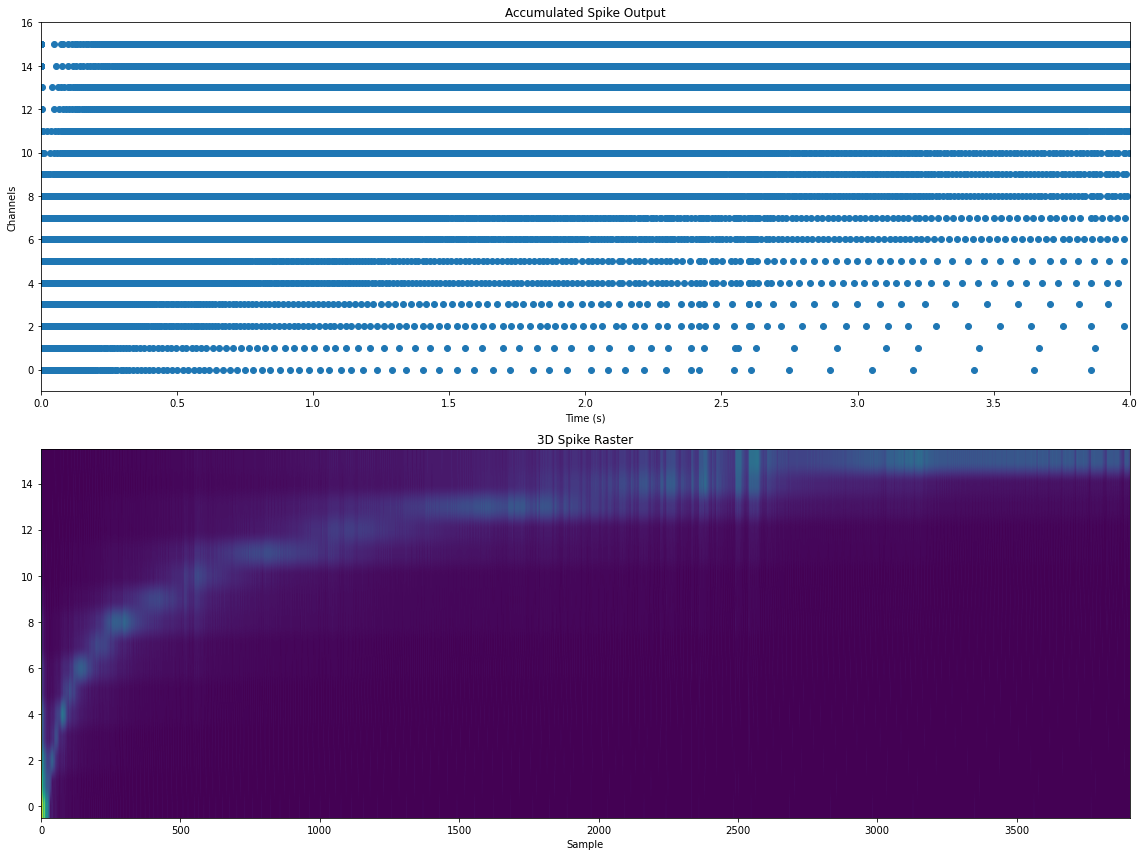

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(16, 12))

# - Plot the raster
plt.sca(axs[0])
TSEvent.from_raster(out, dt=afesim.dt).plot()

# - Plot the 3D image of the raster, color encoding the number of spikes
axs[1].imshow(out.T, aspect="auto", origin="lower")
axs[1].set_xlabel("Sample")
axs[1].set_title("3D Spike Raster")


plt.title("Accumulated Spike Output")
plt.tight_layout()
plt.show()


Due to that down-sampling, and accumulation into a 4-bit spike representation, now the spike raster plot is not self-sufficient to visualize the output. The second figure encodes the number of spikes in one timestep into the color of the pixel. The greener the pixel, the more spikes are accumulated in that timestep.